In [1]:
%matplotlib inline

import numpy as np
import scipy.stats as st
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

import seaborn as sns

import geopandas as gpd

sns.set_theme()
sns.set_style("white", {'xtick.bottom': True, 'ytick.left': True,  'xtick.color': '.02', 'ytick.color': '.02', 'axes.spines.right' : False, 'axes.spines.top' : False,'axes.spines.bottom' : False,'axes.spines.left' : False})
sns.set_palette("deep")
sns.set_context("talk")
palette = sns.color_palette("deep")
palette

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

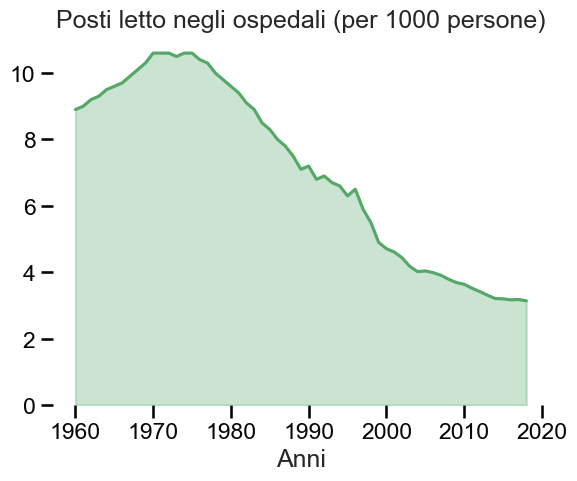

In [2]:
data = pd.read_csv("Datasets/health_ita.csv", sep=",",decimal=".")
data = data.drop(columns=['Country Name','Country ISO3'])
beds = data[data["Indicator Name"] == "Hospital beds (per 1,000 people)"]
beds=beds.drop('Indicator Code',axis=1)

plot_ = sns.lineplot(beds, x="Year", y="Value", color=palette[2])
plt.fill_between(beds['Year'],beds['Value'],alpha=0.3, color=palette[2])
plt.ylim(0)
plot_.set(title="Posti letto negli ospedali (per 1000 persone)", xlabel='Anni',ylabel="")
#plt.savefig("posti_letto.png", bbox_inches='tight', transparent=True)
plt.show()


Cannot find header.dxf (GDAL_DATA is not defined)


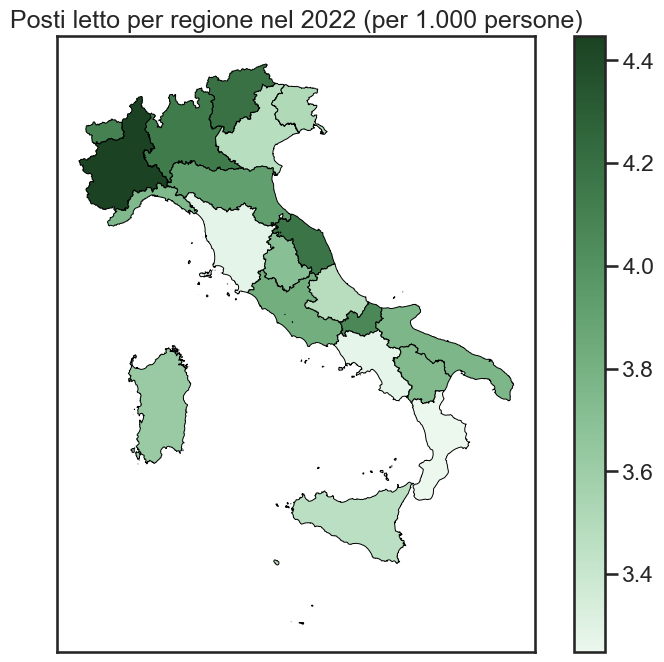

In [3]:
posti_letto_2022 = pd.read_csv("Datasets/Posti_letto_per_struttura_ospedaliera_2022.csv", sep=";",encoding='cp1252')
posti_letto_reg_2022 = posti_letto_2022[["Descrizione Regione","Totale posti letto"]]
posti_letto_reg_2022 = posti_letto_reg_2022.groupby(['Descrizione Regione']).sum()
trentino = posti_letto_reg_2022[posti_letto_reg_2022.index=='PROV. AUTON. BOLZANO']['Totale posti letto'].iloc[0]+posti_letto_reg_2022[posti_letto_reg_2022.index=='PROV. AUTON. TRENTO']['Totale posti letto'].iloc[0]
posti_letto_reg_2022 = posti_letto_reg_2022.drop('PROV. AUTON. BOLZANO')
posti_letto_reg_2022 = posti_letto_reg_2022.drop('PROV. AUTON. TRENTO')
posti_letto_reg_2022.loc['Trentino Alto Adige'] = trentino
posti_letto_reg_2022.sort_index(inplace=True)

pop_reg_2022 = pd.read_csv("Datasets/Popolazione_Regioni_2022.csv", sep=";",thousands=".",index_col=0)
pop_reg_2022.sort_index(inplace=True)
pop_reg_2022 = pop_reg_2022.drop('Provincia Autonoma Bolzano / Bozen')
pop_reg_2022 = pop_reg_2022.drop('Provincia Autonoma Trento')
pop_reg_2022 = pop_reg_2022.set_index(posti_letto_reg_2022.index)

posti_letto_reg_2022_norm = [x[1]["Totale posti letto"] / pop_reg_2022.loc[x[0]].values[0] *1000 for x in posti_letto_reg_2022.iterrows()]
regions = ['Abruzzo', 'Basilicata', 'Calabria', 'Campania', 'Emilia-Romagna',
       'Friuli Venezia Giulia', 'Lazio', 'Liguria', 'Lombardia', 'Marche',
       'Molise', 'Piemonte', 'Puglia', 'Sardegna', 'Sicilia', 'Toscana','Trentino-Alto Adige', 'Umbria', 'Valle d\'Aosta',
       'Veneto']
posti_letto_reg_2022_norm = pd.DataFrame([regions,posti_letto_reg_2022_norm]).transpose()
posti_letto_reg_2022_norm.columns = ['region','quantity']
posti_letto_reg_2022_norm.head()
letti_map_norm = posti_letto_reg_2022_norm.set_index('region').T.to_dict("list")

for key in letti_map_norm:
    letti_map_norm[key] = letti_map_norm[key][0]

sns.set_style("ticks")

# Load shapefile of Italy's regions
italy_regions = gpd.read_file('italy_regions.shp')

# Merge population data with shapefile
italy_regions['beds_norm'] = italy_regions['DEN_REG'].map(letti_map_norm)

colormap = sns.cubehelix_palette(start=2, rot=0, dark=.2, light=.95, reverse=False, as_cmap=True)
# Plot the map
ax = italy_regions.plot(column='beds_norm', cmap=colormap, edgecolor="black", figsize=(10, 8), linewidth=.7, legend=True)
ax.tick_params(left=False, bottom=False)
ax.set(xticklabels=[])
ax.set(yticklabels=[])
ax.set_facecolor("white")
plt.title('Posti letto per regione nel 2022 (per 1.000 persone)')
#plt.savefig("posti_letto_regioni.png", bbox_inches='tight', transparent=True)
plt.show()
#letti_map_norm

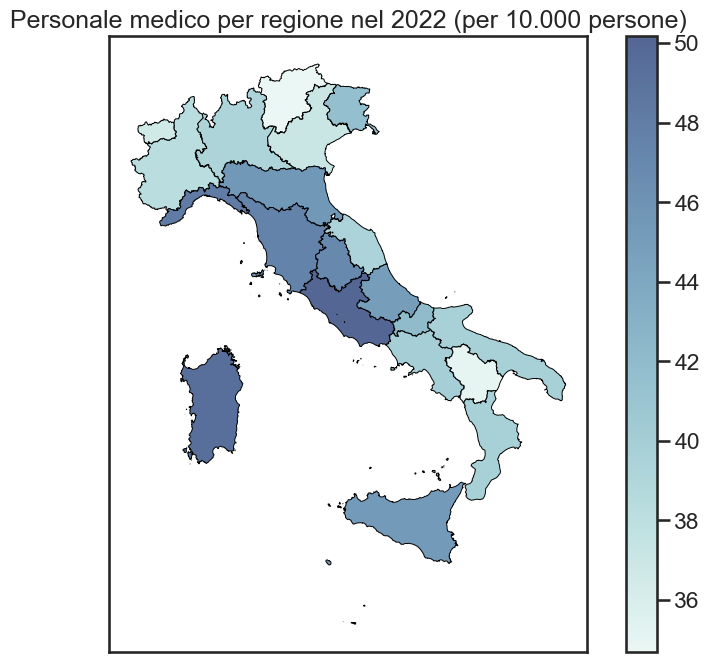

In [5]:
personale_medico = pd.read_csv("Datasets/Personale sanitario_regioni.csv", sep=";",decimal=",",thousands=".")
personale_medico.sort_index(inplace=True)
personale_medico_2022 = personale_medico[["Territorio","2022"]]

personale_medico_map = personale_medico_2022.set_index('Territorio').T.to_dict("list")

for key in personale_medico_map:
    personale_medico_map[key] = personale_medico_map[key][0]

regions = ['Abruzzo', 'Basilicata', 'Calabria', 'Campania', 'Emilia-Romagna',
       'Friuli Venezia Giulia', 'Lazio', 'Liguria', 'Lombardia', 'Marche',
       'Molise', 'Piemonte', 'Puglia', 'Sardegna', 'Sicilia', 'Toscana','Trentino-Alto Adige', 'Umbria', 'Valle d\'Aosta',
       'Veneto']

# Load shapefile of Italy's regions
italy_regions = gpd.read_file('italy_regions.shp')

# Merge population data with shapefile
italy_regions['personale medico per 10000 persone'] = italy_regions['DEN_REG'].map(personale_medico_map)

colormap = sns.cubehelix_palette(start=.2, rot=-.3, dark=.4, light=.95, reverse=False, as_cmap=True)

# Plot the map
ax = italy_regions.plot(column='personale medico per 10000 persone', cmap=colormap, edgecolor="black", figsize=(10, 8), linewidth=.7, legend=True)

ax.tick_params(left=False, bottom=False)
ax.set(xticklabels=[])
ax.set(yticklabels=[])
ax.set_facecolor("white")

 
 
plt.title('Personale medico per regione nel 2022 (per 10.000 persone)')
#plt.savefig("personale_medico_regioni.png", bbox_inches='tight', transparent=True)
plt.show()

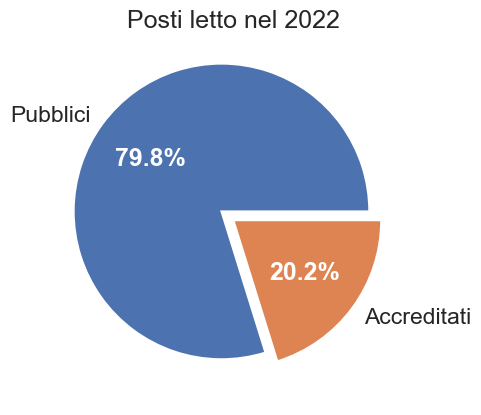

In [6]:
posti_letto_2022=pd.read_csv("Datasets/Posti_letto_2022.csv",sep=";",decimal=",",thousands=".", index_col=0)
posti_letto_2022=posti_letto_2022.drop("Totale posti letto")
myexplode=[0.1,0]
_,_,labels=plt.pie(posti_letto_2022.Totale,explode=myexplode,autopct='%1.1f%%',labels=["Pubblici","Accreditati"],colors=palette)
plt.title("Posti letto nel 2022")
plt.setp(labels,color='white',fontweight='bold')
#fontweight='bold'
#plt.savefig("posti_letto_pie.png", bbox_inches='tight', transparent=True)
plt.show()

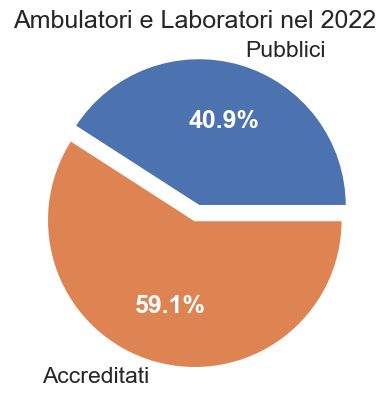

In [7]:
strutture_sanitarie_2022=pd.read_csv("Datasets/Strutture_sanitarie_2022.csv",sep=";",decimal=",",thousands=".", index_col=0)
myexplode=[0.1,0]
_,_,labels=plt.pie(strutture_sanitarie_2022["Ambulatori e Laboratori"],explode=myexplode,autopct='%1.1f%%',labels=["Pubblici","Accreditati"],colors=palette)
plt.title("Ambulatori e Laboratori nel 2022")
plt.setp(labels,color='white',fontweight='bold')
#plt.savefig("ambulatori_lab_pie.png", bbox_inches='tight', transparent=True)
plt.show()

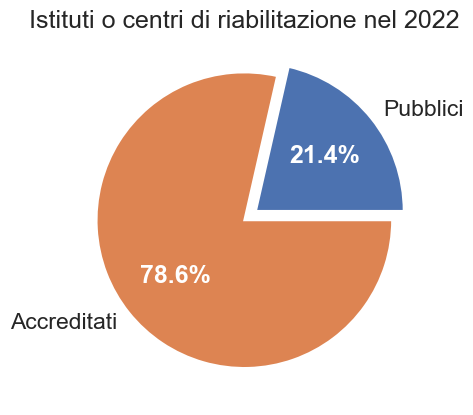

In [8]:
istituti_riabilitazione_2022 = pd.read_csv("Datasets/Istituti_riabilitazione_2022.csv",sep=";",decimal=",",thousands=".",index_col=0)
istituti_riabilitazione_2022
myexplode=[0.1,0]
_,_,labels=plt.pie(istituti_riabilitazione_2022["Quantità"].drop("Totale"),explode=myexplode,autopct='%1.1f%%',labels=["Pubblici","Accreditati"],colors=palette)
plt.title("Istituti o centri di riabilitazione nel 2022")
plt.setp(labels,color='white',fontweight='bold')
#plt.savefig("istituti_centri_riab.png", bbox_inches='tight', transparent=True)
plt.show()

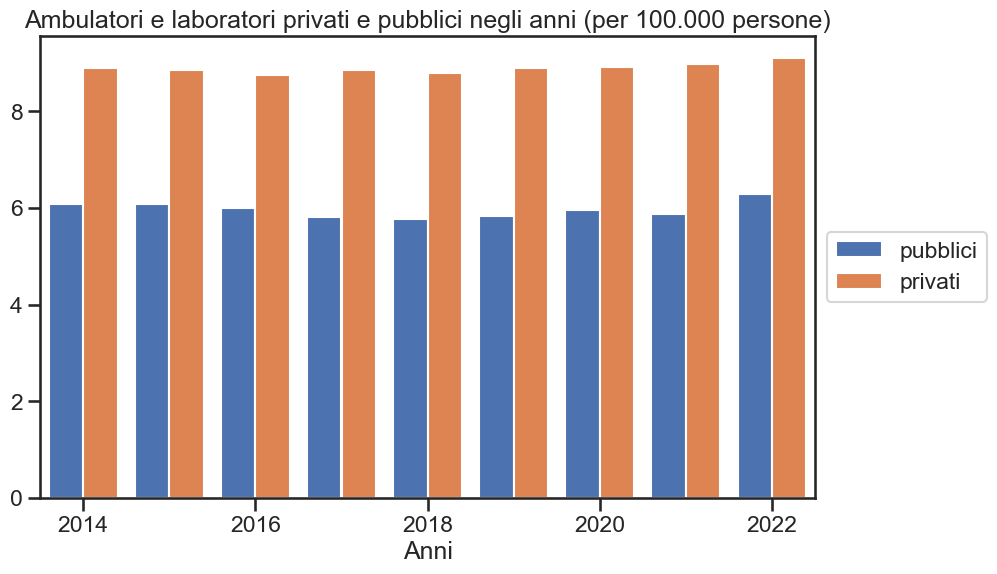

In [9]:
private_pubbliche_anni=pd.read_csv("Datasets/Strutture_private_pubbliche.csv",sep=";",decimal=",",thousands=".", index_col=0)
private_pubbliche_anni = private_pubbliche_anni.T
df_melted = private_pubbliche_anni.reset_index().melt(id_vars=["index"], var_name="Tipo Dato", value_name="Valore")

plt.figure(figsize=(10,6))
sns.barplot(df_melted, x='index', y='Valore', hue='Tipo Dato', palette=palette[0:2], saturation=1)
plt.title("Ambulatori e laboratori privati e pubblici negli anni (per 100.000 persone)")
plt.ylabel("")
plt.xlabel("Anni")
plt.xticks(["2014","2016","2018","2020","2022"])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#plt.savefig("ambulatori_lab_anni.png", bbox_inches='tight', transparent=True)
plt.show()

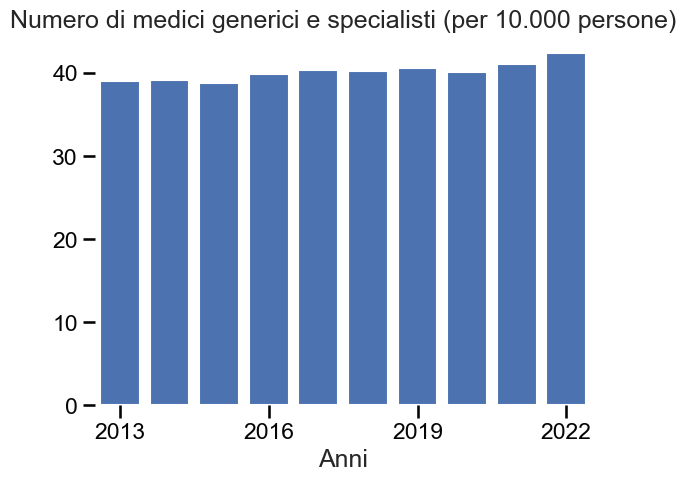

In [10]:
sns.set_style("white", {'xtick.bottom': True, 'ytick.left': True,  'xtick.color': '.02', 'ytick.color': '.02', 'axes.spines.right' : False, 'axes.spines.top' : False,'axes.spines.bottom' : False,'axes.spines.left' : False})
personale_medico = pd.read_csv("Datasets/Personale sanitario.csv", sep=";",decimal=",",thousands=".")
personale_medico = personale_medico.T
plot_ = sns.barplot(personale_medico, x=personale_medico.index, y="Totale medici (generici e specialisti)", saturation=1)
plot_.set(title="Numero di medici generici e specialisti (per 10.000 persone)", xlabel='Anni', ylabel='')
plt.xticks(["2013","2016","2019","2022"])
plt.ylim(0)
#plt.savefig("numero_medici.png", bbox_inches='tight', transparent=True)
plt.show()

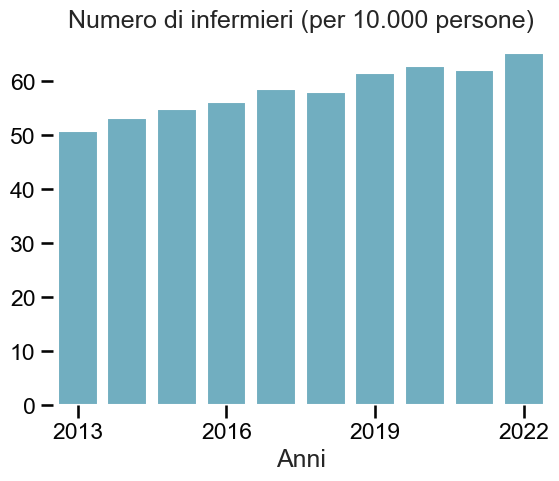

In [11]:
plot_ = sns.barplot(personale_medico, x=personale_medico.index, y="Professioni sanitarie infermieristiche", color=palette[9])
plot_.set(title="Numero di infermieri (per 10.000 persone)", xlabel='Anni', ylabel='')
plt.xticks(["2013","2016","2019","2022"])
plt.ylim(0)
#plt.savefig("numero_infermieri.png", bbox_inches='tight', transparent=True)
plt.show()

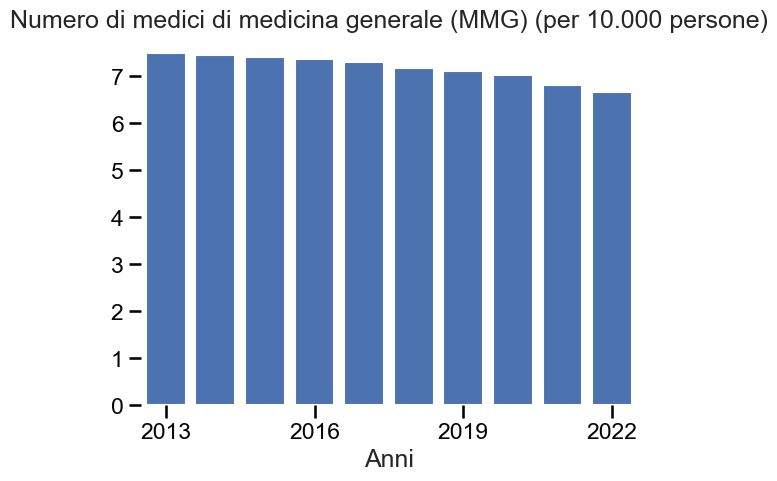

In [12]:
plot_ = sns.barplot(personale_medico, x=personale_medico.index, y="Medici di medicina generale (MMG)",color=palette[0], saturation=1)
plot_.set(title="Numero di medici di medicina generale (MMG) (per 10.000 persone)", xlabel='Anni', ylabel='')
plt.xticks(["2013","2016","2019","2022"])
plt.ylim(0)
#plt.savefig("numero_med_generale.png", bbox_inches='tight', transparent=True)
plt.show()

8660.846153846154


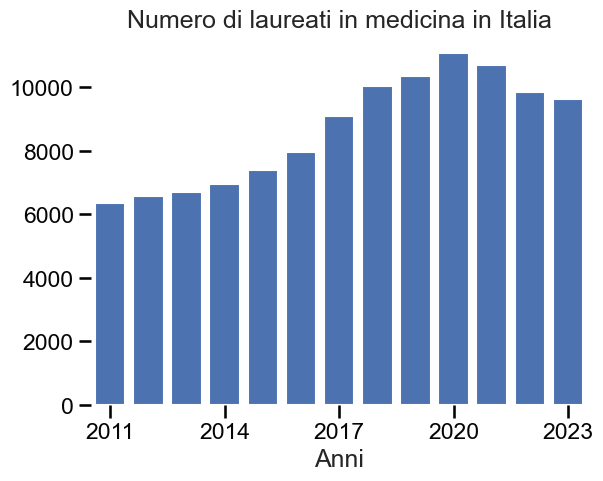

In [13]:
laureati_medicina = pd.read_csv("Datasets/laureati_corso_2010-2017.csv",sep=";",encoding='cp1252')
laureati_medicina = laureati_medicina.drop(columns=["AteneoCOD","AteneoNOME","SedeC","SedeP","Sesso"])
laureati_medicina = laureati_medicina[(laureati_medicina["ClasseNUMERO"]=="LM-41") | (laureati_medicina["ClasseNUMERO"]=="46/S")]
laureati_medicina = laureati_medicina.groupby(['AnnoS'])['Lau'].sum()

laureati_medicina_2 = pd.read_csv("Datasets/laureati_corso_2018-2023.csv",sep=";",encoding='cp1252')
laureati_medicina_2 = laureati_medicina_2.drop(columns=["COD_Ateneo","NomeOperativo","COMUNE","ID_PROVINCIA_ISTAT","ID_SESSO"])
laureati_medicina_2 = laureati_medicina_2[(laureati_medicina_2["NUMERO"]=="LM-41") | (laureati_medicina_2["NUMERO"]=="46/S")]
laureati_medicina_2 = laureati_medicina_2.groupby(['ANNO_LAUREA'])['laureati'].sum()

tot = pd.concat([laureati_medicina,laureati_medicina_2])
tot = tot.drop([2010])


print(tot.loc[2011:].sum()/13)

sns.set_style("white", {'xtick.bottom': True, 'ytick.left': True,  'xtick.color': '.02', 'ytick.color': '.02', 'axes.spines.right' : False, 'axes.spines.top' : False,'axes.spines.bottom' : False,'axes.spines.left' : False})
ax= sns.barplot(x=tot.index, y=tot, color=palette[0], saturation=1)
ax.set(title="Numero di laureati in medicina in Italia",xlabel="Anni",ylabel="")
plt.xticks(["2011","2014","2017","2020","2023"])
#plt.savefig("laureati_medicina.png", bbox_inches='tight', transparent=True)
plt.show()


['Austria' 'Belgium' 'Canada' 'Finland' 'France' 'Germany' 'Ireland'
 'New Zealand' 'Spain' 'Sweden' 'United Kingdom' 'United States' 'Israel'
 'Norway' 'Switzerland']
1129.6


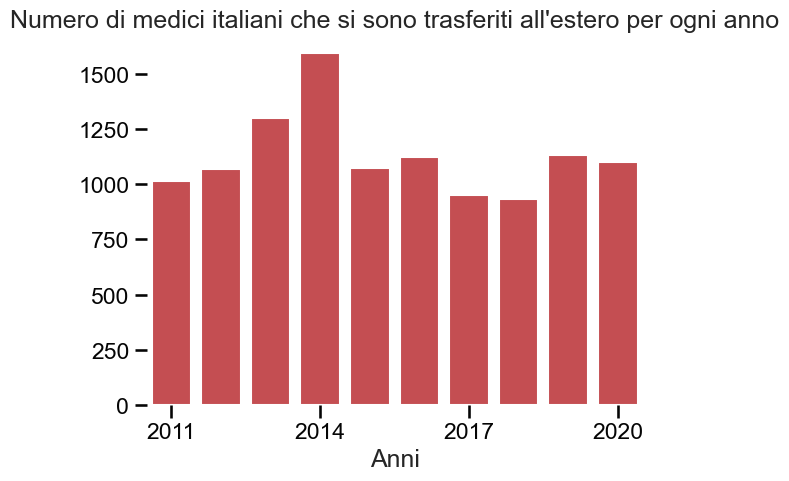

In [14]:
#INFLOW DEI MEDICI ITALIANI ALL'ESTERO
#E INFLOW DEI MEDICI ESTERI IN ITALIA
#https://stats.oecd.org/index.aspx?lang=en

sns.set_style("white", {'xtick.bottom': True, 'ytick.left': True,  'xtick.color': '.02', 'ytick.color': '.02', 'axes.spines.right' : False, 'axes.spines.top' : False,'axes.spines.bottom' : False,'axes.spines.left' : False})

medici_esteri_per_paese_inflow = pd.read_csv("Datasets/medici_esteri_annui.csv",sep=",")
#Alcuni dati sono segnati come 'Difference in methodology' oppure 'Break'
medici_esteri_per_paese_inflow = medici_esteri_per_paese_inflow.drop(columns=["COU","CO2","YEA","VAR","Variable","Flag Codes","Flags"])
medici_italiani_per_paese_inflow= medici_esteri_per_paese_inflow[medici_esteri_per_paese_inflow["Country of origin"]=="Italy"]
medici_italiani_per_paese_inflow = medici_italiani_per_paese_inflow[~medici_italiani_per_paese_inflow.Country.isin(["Czechia","Denmark","Hungary","Estonia","Slovenia","Netherlands","Latvia","Chile",'Türkiye',"Poland"])]

#for i in range(2011,2021):
#    print(medici_italiani_per_paese_inflow[medici_italiani_per_paese_inflow["Year"]==i].Country.unique())

print(medici_italiani_per_paese_inflow[medici_italiani_per_paese_inflow["Year"]==2020].Country.unique())

medici_italiani_totale_inflow= medici_italiani_per_paese_inflow.groupby(["Year"]).sum()
medici_italiani_totale_inflow=medici_italiani_totale_inflow.loc[2011:2020]


print(medici_italiani_totale_inflow.Value.sum()/10)

sns.barplot(medici_italiani_totale_inflow, x=medici_italiani_totale_inflow.index, y="Value",color=palette[3], saturation=1)
plt.xticks(["2011","2014","2017","2020"])
plt.ylabel("")
plt.xlabel("Anni")
plt.title("Numero di medici italiani che si sono trasferiti all'estero per ogni anno")
#plt.savefig("medici_italiani_estero_outflow.png", bbox_inches='tight', transparent=True)
plt.show()


In [15]:
#MEDICI IN BASE ALL'ETà
#https://stats.oecd.org/index.aspx?lang=en
medici_età = pd.read_csv("Datasets/physicians_by_age.csv")
medici_età = medici_età.drop(columns=["VAR","UNIT","COU","YEA","Flag Codes","Flags"])
medici_età = medici_età[medici_età["Variable"].isin([
       'Total physicians under 35 years old',
       'Total physicians aged 35-44 years old',
       'Total physicians aged 45-54 years old',
       'Total physicians aged 55-64 years old',
       'Total physicians aged 65-74 years old',
       'Total physicians aged 75 years old and over'])]
medici_età = medici_età[medici_età["Year"]>2012]
medici_età = medici_età[medici_età["Measure"].isin(['% of total physicians (head counts)'])]

medici_età_italiani = medici_età[medici_età["Country"]=="Italy"].drop(columns=["Country","Measure"])

In [16]:
medici_età = pd.read_csv("Datasets/physicians_by_age.csv")
medici_età = medici_età.drop(columns=["VAR","UNIT","COU","YEA","Flag Codes","Flags"])
medici_età = medici_età[medici_età["Variable"].isin([
       'Total physicians under 35 years old',
       'Total physicians aged 35-44 years old',
       'Total physicians aged 45-54 years old',
       'Total physicians aged 55-64 years old',
       'Total physicians aged 65-74 years old',
       'Total physicians aged 75 years old and over'])]
medici_età = medici_età[medici_età["Year"]>2012]

medici_età = medici_età[medici_età["Measure"].isin(['Number of persons (head counts)'])]
medici_età_italiani = medici_età[medici_età["Country"]=="Italy"].drop(columns=["Country","Measure"])

medici_età_italiani[medici_età_italiani["Year"]==2021]

Variable  Year    Value
2865           Total physicians under 35 years old  2021  23497.0
2878         Total physicians aged 35-44 years old  2021  43453.0
2891         Total physicians aged 45-54 years old  2021  41737.0
2904         Total physicians aged 55-64 years old  2021  73393.0
2917         Total physicians aged 65-74 years old  2021  56170.0
14464  Total physicians aged 75 years old and over  2021   4471.0

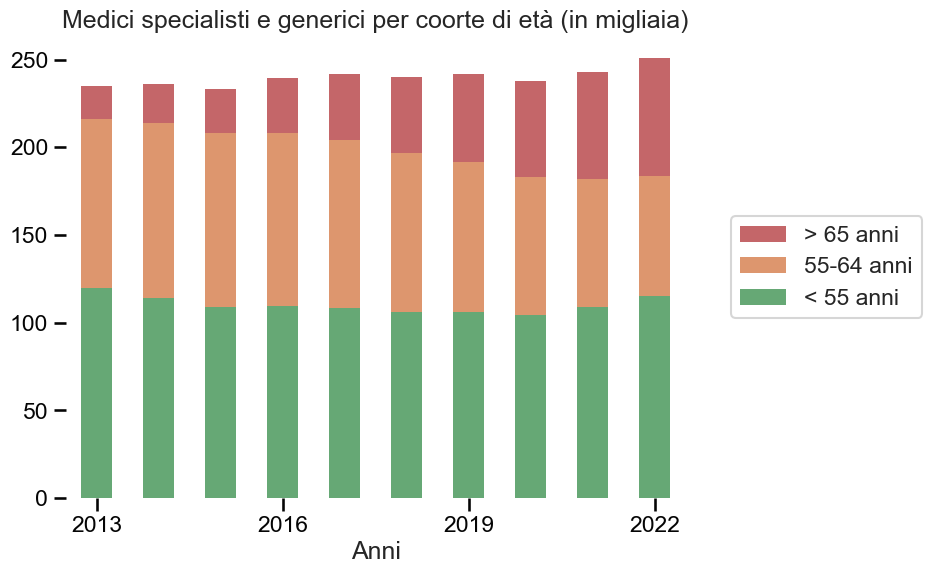

In [17]:
medici_sopra_55 = medici_età_italiani[medici_età_italiani["Variable"].isin(['Total physicians aged 55-64 years old',
       'Total physicians aged 65-74 years old',
       'Total physicians aged 75 years old and over'])]
medici_sopra_55 = medici_sopra_55.groupby("Year").sum()

medici_sotto_55 = medici_età_italiani[medici_età_italiani["Variable"].isin(['Total physicians under 35 years old',
       'Total physicians aged 35-44 years old',
       'Total physicians aged 45-54 years old'])]
medici_sotto_55 = medici_sotto_55.groupby("Year").sum()

sopra55= medici_sopra_55.rename(columns={'Value': '> 55 anni'}).drop(columns=["Variable"])
sotto55= medici_sotto_55.rename(columns={'Value': '< 55 anni'}).drop(columns=["Variable"])

sotto35=medici_età_italiani[medici_età_italiani["Variable"]=="Total physicians under 35 years old"]
sotto35=sotto35.set_index("Year").rename(columns={'Value': '< 35 anni'}).drop(columns=["Variable"])

sotto44=medici_età_italiani[medici_età_italiani["Variable"]=="Total physicians aged 35-44 years old"]
sotto44=sotto44.set_index("Year").rename(columns={'Value': '35-44 anni'}).drop(columns=["Variable"])

sotto54=medici_età_italiani[medici_età_italiani["Variable"]=="Total physicians aged 45-54 years old"]
sotto54=sotto54.set_index("Year").rename(columns={'Value': '45-54 anni'}).drop(columns=["Variable"])

sotto64=medici_età_italiani[medici_età_italiani["Variable"]=="Total physicians aged 55-64 years old"]
sotto64=sotto64.set_index("Year").rename(columns={'Value': '55-64 anni'}).drop(columns=["Variable"])

sotto74=medici_età_italiani[medici_età_italiani["Variable"]=="Total physicians aged 65-74 years old"]
sotto74=sotto74.set_index("Year").rename(columns={'Value': '65-74 anni'}).drop(columns=["Variable"])

sopra75=medici_età_italiani[medici_età_italiani["Variable"]=="Total physicians aged 75 years old and over"]
sopra75=sopra75.set_index("Year").rename(columns={'Value': '> 75 anni'}).drop(columns=["Variable"])


sopra35sotto54 = medici_età_italiani[medici_età_italiani["Variable"].isin([
       'Total physicians aged 35-44 years old',
       'Total physicians aged 45-54 years old'])]
sopra35sotto54 = sopra35sotto54.groupby("Year").sum()


sopra65 = medici_età_italiani[medici_età_italiani["Variable"].isin([
       'Total physicians aged 65-74 years old',
       'Total physicians aged 75 years old and over'])]
sopra65 = sopra65.groupby("Year").sum()

sopra35sotto54= sopra35sotto54.rename(columns={'Value': '35-54 anni'}).drop(columns=["Variable"])
sopra65= sopra65.rename(columns={'Value': '> 65 anni'}).drop(columns=["Variable"])

#tot_età = pd.concat([sotto35,sopra35sotto54,sotto64,sopra65], axis=1)
tot_età = pd.concat([sotto55,sotto64,sopra65], axis=1)
tot_età=tot_età/1000

sns.set_style("white", {'xtick.bottom': True, 'ytick.left': True,  'xtick.color': '.02', 'ytick.color': '.02', 'axes.spines.right' : False, 'axes.spines.top' : False,'axes.spines.bottom' : False,'axes.spines.left' : False})

def desaturate(color, amount=0.8):
    #color = np.array(color) / 255.0  # Convertire RGB da 0-255 a 0-1
    hsv = rgb_to_hsv(color)  # Convertire da RGB a HSV
    hsv[1] *= amount  # Ridurre la saturazione
    desaturated_color = hsv_to_rgb(hsv)  # Convertire da HSV a RGB
    return desaturated_color

# Desaturare i colori nella palette
desaturated_palette = [desaturate(color) for color in palette]

#ax = tot_età.plot(kind='bar', stacked=True,linewidth=0,color=[palette[0],palette[9],palette[1],palette[3],palette[4],palette[5]],rot=0)
ax = tot_età.plot(kind='bar', stacked=True,linewidth=0,color=[desaturated_palette[2],desaturated_palette[1],desaturated_palette[3]],rot=0,figsize=(8,6))

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc='center right',bbox_to_anchor=(1.4, 0.5))


plt.xlabel("Anni")

plt.title("Medici specialisti e generici per coorte di età (in migliaia)")
plt.xticks([0,3,6,9])
#plt.savefig("medici_età.png", bbox_inches='tight', transparent=True)
plt.show()

In [18]:
salaries = pd.read_csv("Datasets/doctor_salary_europe.csv")
salaries = salaries.drop(columns=["VAR", "UNIT", "COU", "YEA", "Flag Codes", "Flags"])
salaries = salaries[salaries["Measure"] == 'Salaried, income, US$ exchange rate']
salaries.loc[:,"Value"]=salaries.Value/1000

nurses = salaries[salaries["Variable"] == "Remuneration of hospital nurses"].drop(columns="Variable")
specialists = salaries[salaries["Variable"] == "Remuneration of specialists"].drop(columns="Variable")


In [19]:
nurses_it = nurses[nurses["Country"] == "Italy"].drop(columns=["Country","Measure"]).set_index("Year")
specialists_it = specialists[specialists["Country"] == "Italy"].drop(columns=["Country","Measure"]).set_index("Year")
nurses_it=nurses_it.rename(columns={"Value":"Infermieri"})
specialists_it=specialists_it.rename(columns={"Value":"Medici Specialisti"})
salaries_it = pd.merge(specialists_it,nurses_it,left_index=True,right_index=True)
salaries_it=salaries_it.reset_index().rename(columns={"Year":"index"})

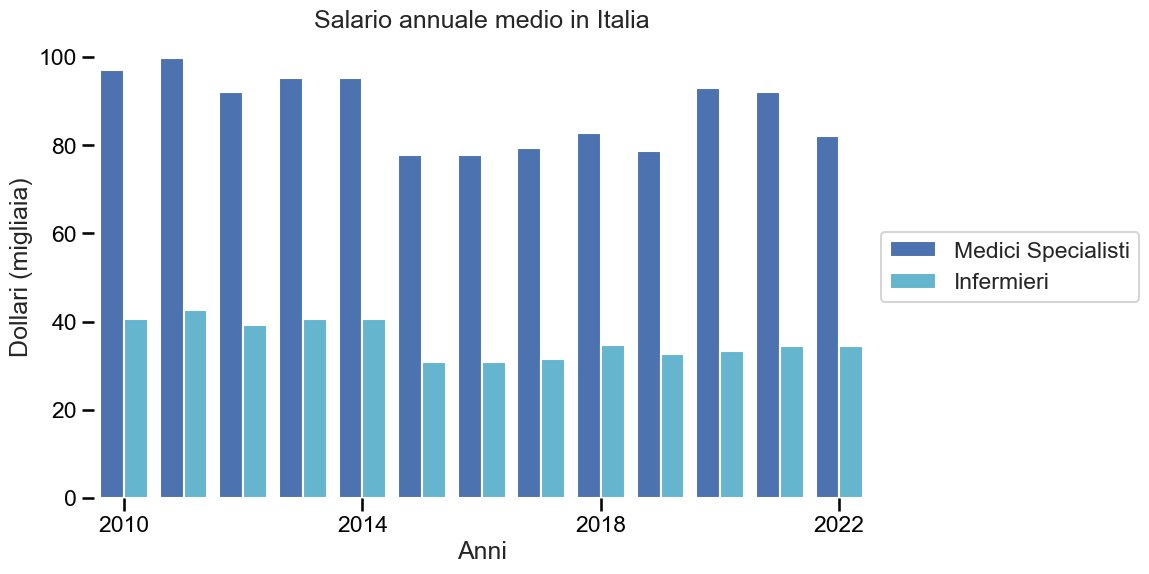

In [20]:
sns.set_style("white", {'xtick.bottom': True, 'ytick.left': True,  'xtick.color': '.02', 'ytick.color': '.02', 'axes.spines.right' : False, 'axes.spines.top' : False,'axes.spines.bottom' : False,'axes.spines.left' : False})
df_melted =  salaries_it.melt(id_vars=["index"], var_name="Tipo Dato", value_name="Valore")
plt.figure(figsize=(10,6))
sns.barplot(df_melted, x='index', y='Valore', hue='Tipo Dato', palette=[palette[0], palette[9]], saturation=1)
plt.title("Salario annuale medio in Italia")
plt.ylabel("Dollari (migliaia)")
plt.xlabel("Anni")
plt.xticks(["2010","2014","2018","2022"])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

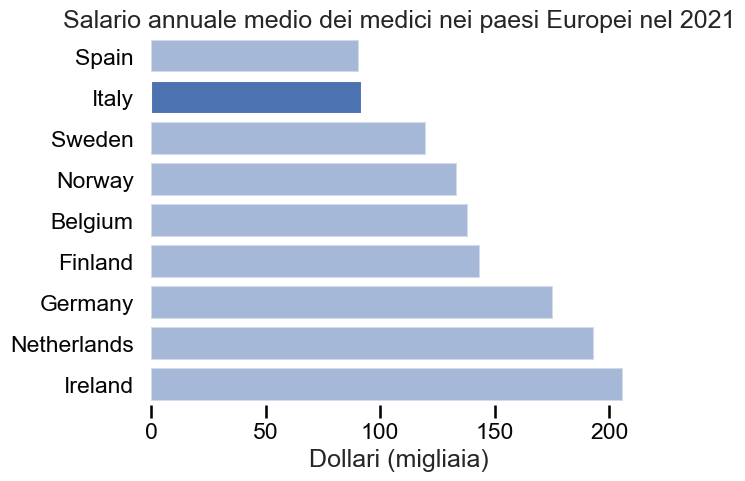

In [21]:
salaries = pd.read_csv("Datasets/doctor_salary_europe.csv")
salaries = salaries.drop(columns=["VAR", "UNIT", "COU", "YEA", "Flag Codes", "Flags"])
salaries = salaries[salaries["Measure"] == 'Salaried, income, US$ exchange rate']
salaries.loc[:,"Value"]=salaries.Value/1000
sns.set_style("white", {'xtick.bottom': True, 'ytick.left': False,  'xtick.color': '.02', 'ytick.color': '.02', 'axes.spines.right' : False, 'axes.spines.top' : False,'axes.spines.bottom' : False,'axes.spines.left' : False})

specialists = salaries[salaries["Variable"] == "Remuneration of specialists"].drop(columns="Variable")


countries = ['Belgium', 'Finland', 'France', "Netherlands" ,"Italy",'Ireland','Spain',"Germany", 'Sweden', 'United Kingdom',
             'Norway', 'Switzerland']

specialists = specialists[specialists["Country"].isin(countries)]

specialists2021=specialists[specialists["Year"] == 2021]

ax = sns.barplot(specialists2021, x='Value', y='Country', color=palette[0], saturation=1,order=specialists2021.sort_values("Value").Country, alpha=0.5)
sns.barplot(specialists2021[specialists2021["Country"] == "Italy"], x='Value', y='Country', color=palette[0], saturation=1,order=specialists2021.sort_values("Value").Country, alpha=1, ax=ax)

plt.title("Salario annuale medio dei medici nei paesi Europei nel 2021")
plt.ylabel("")
plt.xlabel("Dollari (migliaia)")
#plt.savefig("salario_annuale_medici_europa.png", bbox_inches='tight', transparent=True)
plt.show()

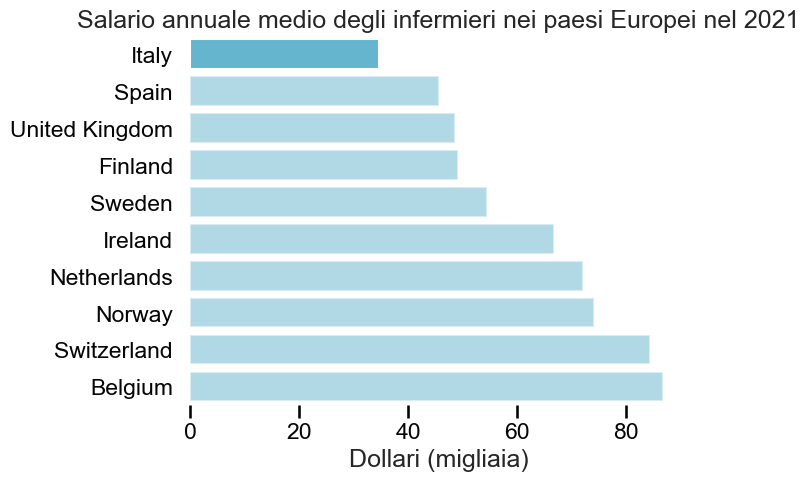

In [22]:
salaries = pd.read_csv("Datasets/doctor_salary_europe.csv")
salaries = salaries.drop(columns=["VAR", "UNIT", "COU", "YEA", "Flag Codes", "Flags"])
salaries = salaries[salaries["Measure"] == 'Salaried, income, US$ exchange rate']
salaries.loc[:,"Value"]=salaries.Value/1000
sns.set_style("white", {'xtick.bottom': True, 'ytick.left': False,  'xtick.color': '.02', 'ytick.color': '.02', 'axes.spines.right' : False, 'axes.spines.top' : False,'axes.spines.bottom' : False,'axes.spines.left' : False})

nurses = salaries[salaries["Variable"] == "Remuneration of hospital nurses"].drop(columns="Variable")
countries = ['Belgium', 'Finland', 'France', "Netherlands" ,"Italy",'Ireland','Spain',"Germany", 'Sweden', 'United Kingdom',
             'Norway', 'Switzerland']

nurses = nurses[nurses["Country"].isin(countries)]

nurses2021 = nurses[nurses["Year"] == 2021]

ax = sns.barplot(nurses2021, x='Value', y='Country', color=palette[9], saturation=1, order=nurses2021.sort_values("Value").Country, alpha=0.5)
sns.barplot(nurses2021[nurses2021["Country"] == "Italy"], x='Value', y='Country', color=palette[9], saturation=1, order=nurses2021.sort_values("Value").Country, alpha=1, ax=ax)


plt.ylabel("")
plt.title("Salario annuale medio degli infermieri nei paesi Europei nel 2021")
plt.xlabel("Dollari (migliaia)")

#plt.savefig("salario_annuale_infermieri_europa.png", bbox_inches='tight', transparent=True)
plt.show()

In [23]:
expenditure = pd.read_csv("Datasets/expenditure_on_health.csv", encoding='latin-1')
expenditure_2020 = expenditure[expenditure["Year"] == 2020]
expenditure_2020 = expenditure_2020.drop(columns=["Region","Source","Footnotes"])
expenditure_gdp = expenditure_2020[expenditure_2020["Series"] == "Current health expenditure (% of GDP)"].drop(columns=["Series"])


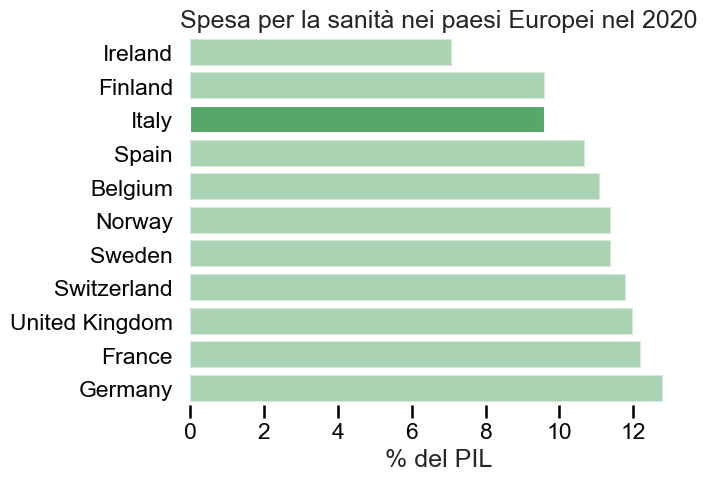

In [24]:
countries = ['Belgium', 'Finland', 'France', "Netherlands" ,"Italy",'Ireland','Spain',"Germany", 'Sweden', 'United Kingdom',
             'Norway', 'Switzerland']

expenditure_gdp = expenditure_gdp[expenditure_gdp["Country"].isin(countries)]
ax=sns.barplot(expenditure_gdp, x='Value', y='Country', color=palette[2], saturation=1,order=expenditure_gdp.sort_values("Value").Country, alpha=0.5)
sns.barplot(expenditure_gdp[expenditure_gdp["Country"] == "Italy"], x='Value', y='Country', color=palette[2], saturation=1,order=expenditure_gdp.sort_values("Value").Country, alpha=1, ax=ax)
plt.title("Spesa per la sanità nei paesi Europei nel 2020")
plt.ylabel("")
plt.xlabel("% del PIL")
#plt.savefig("spesa_sanità_europa.png", bbox_inches='tight', transparent=True)
plt.show()

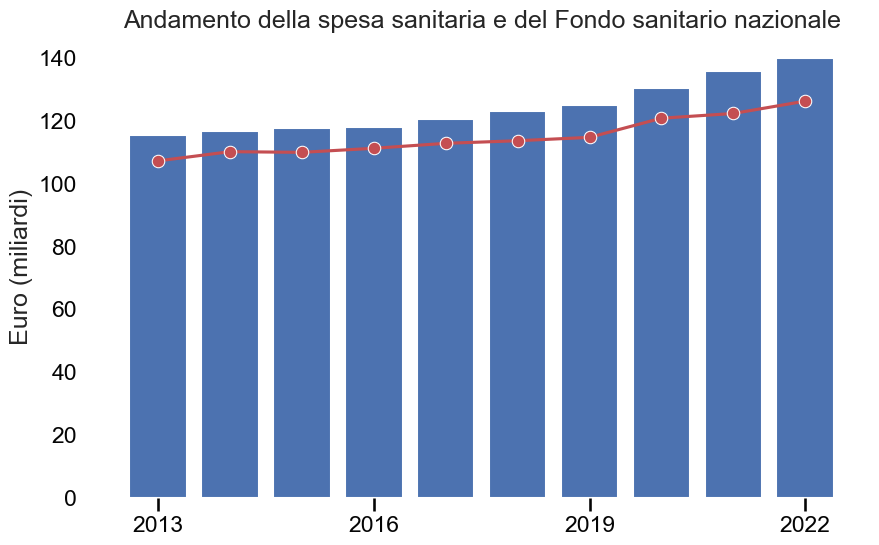

In [25]:
spesa_sanitaria_ita = pd.read_csv("Datasets/spesa_sanitaria_ita.csv",sep=",",thousands=".")
spesa_sanitaria_ita.astype({"Anno": str})
spesa_sanitaria_ita.set_index("Anno", inplace=True)
spesa_sanitaria_ita = spesa_sanitaria_ita.div(1000000000)
spesa_sanitaria_ita.drop(columns=["Fondo Sanitario Nazionale"], inplace=True)
spesa_sanitaria_ita = spesa_sanitaria_ita.sum(axis=1)

fondo_sanitario_ita = pd.read_csv("Datasets/spesa_sanitaria_ita.csv",sep=",",thousands=".")
fondo_sanitario_ita.astype({"Anno": str})
fondo_sanitario_ita.set_index("Anno", inplace=True)
fondo_sanitario_ita = fondo_sanitario_ita["Fondo Sanitario Nazionale"]
fondo_sanitario_ita = fondo_sanitario_ita.div(1000000000)

# Conversione degli indici in stringa
spesa_sanitaria_ita.index = spesa_sanitaria_ita.index.astype(str)
fondo_sanitario_ita.index = fondo_sanitario_ita.index.astype(str)

df1 = spesa_sanitaria_ita.reset_index()
df1.columns = ['Anno', 'Valore1']
df2 = fondo_sanitario_ita.reset_index()
df2.columns = ['Anno', 'Valore2']

df1 = df1.drop(df1[df1.Anno.isin(["2012"])].index)
df2 = df2.drop(df2[df2.Anno.isin(["2012"])].index)

# Creazione del grafico
plt.figure(figsize=(10, 6))

# Barplot per il primo dataset
ax = sns.barplot(x='Anno', y='Valore1', data=df1, color=palette[0],saturation=1)

# Lineplot per il secondo dataset
ax = sns.lineplot(x='Anno', y='Valore2', data=df2, color=palette[3], marker='o')

sns.set_style("white", {'xtick.bottom': True, 'ytick.left': True,  'xtick.color': '.02', 'ytick.color': '.02', 'axes.spines.right' : False, 'axes.spines.top' : False,'axes.spines.bottom' : False,'axes.spines.left' : False})
ax.set(xlabel='', ylabel='Euro (miliardi)')
plt.title("Andamento della spesa sanitaria e del Fondo sanitario nazionale")
plt.xticks(["2013","2016","2019", "2022"])

#plt.savefig("spesa_sanitaria.png", bbox_inches='tight', transparent=True)
plt.show()
